##[1주차] 기본과제: MNIST를 분류 모델로 학습하기

Epoch 1/100: Train Loss: 539.5753, Test Loss: 91.4150
Epoch 1: Train Acc: 0.2329, Test Acc: 0.2397
Epoch 2/100: Train Loss: 535.0257, Test Loss: 90.6089
Epoch 2: Train Acc: 0.3705, Test Acc: 0.3804
Epoch 3/100: Train Loss: 530.3124, Test Loss: 89.7568
Epoch 3: Train Acc: 0.4808, Test Acc: 0.4964
Epoch 4/100: Train Loss: 525.2381, Test Loss: 88.8254
Epoch 4: Train Acc: 0.5484, Test Acc: 0.5626
Epoch 5/100: Train Loss: 519.6055, Test Loss: 87.7789
Epoch 5: Train Acc: 0.5898, Test Acc: 0.6023
Epoch 6/100: Train Loss: 513.1881, Test Loss: 86.5782
Epoch 6: Train Acc: 0.6175, Test Acc: 0.6267
Epoch 7/100: Train Loss: 505.7943, Test Loss: 85.1814
Epoch 7: Train Acc: 0.6375, Test Acc: 0.6496
Epoch 8/100: Train Loss: 497.1293, Test Loss: 83.5448
Epoch 8: Train Acc: 0.6540, Test Acc: 0.6639
Epoch 9/100: Train Loss: 486.9761, Test Loss: 81.6241
Epoch 9: Train Acc: 0.6699, Test Acc: 0.6808
Epoch 10/100: Train Loss: 475.1045, Test Loss: 79.3791
Epoch 10: Train Acc: 0.6844, Test Acc: 0.6923
Epoch 11

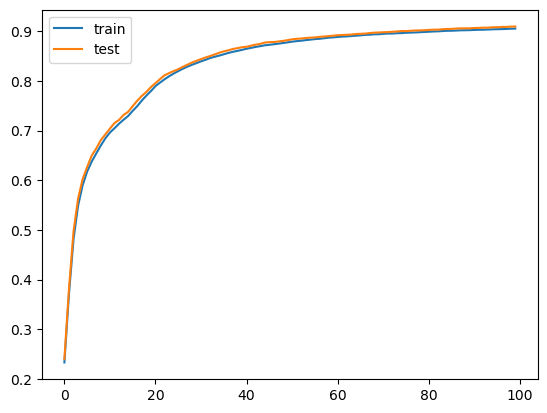

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋 변환 및 로드
transform = transforms.ToTensor()

# 훈련 데이터셋
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

# 테스트 데이터셋
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

# 모델 정의 (출력층 크기는 10으로 설정, MNIST는 10개 클래스)
class Model(nn.Module):
    def __init__(self, input_dim, n_dim, num_classes):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, num_classes)  # 출력층 뉴런 수를 클래스 개수로 변경

        self.act = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 28x28 -> 784
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)  # 출력층에 활성화 함수 사용하지 않음 (CrossEntropyLoss에 의해 처리됨)

        return x

# 모델 초기화
model = Model(28 * 28, 1024, 10)  # MNIST는 28x28 크기의 이미지를 784 차원 벡터로 처리

# 정확도 계산 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    # 평가 모드로 설정 (Dropout 및 BatchNorm 비활성화)
    model.eval()

    with torch.no_grad():  # 기울기 계산 비활성화
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('mps'), labels.to('mps')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# 정확도 시각화 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.show()

# 손실 함수 정의 및 학습 함수
def train(model, loader, optimizer, criterion):
    total_loss = 0.
    model.train()  # 훈련 모드로 설정
    for data in loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('mps'), labels.to('mps')

        preds = model(inputs)  # 예측값 계산
        loss = criterion(preds, labels)  # CrossEntropyLoss 사용

        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()

    return total_loss

# 하이퍼파라미터 설정
lr = 0.001
n_epochs = 100
batch_size = 256

# 모델과 손실 함수 및 옵티마이저 설정
model = model.to('mps')  # 모델을 MPS 디바이스로 이동
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용
optimizer = SGD(model.parameters(), lr=lr)  # SGD 옵티마이저 사용

# 정확도 기록 리스트
train_accs = []
test_accs = []

# 학습 시작
for epoch in range(n_epochs):
    # 훈련 데이터셋에 대해 손실 계산
    train_loss = loss(model, trainloader, optimizer, criterion)

    # 테스트 데이터셋에 대해 손실 계산 (교차 검증)
    test_loss = loss(model, testloader, optimizer, criterion)

    # 훈련 및 테스트 정확도 계산
    train_acc = accuracy(model, trainloader)
    test_acc = accuracy(model, testloader)

    # 정확도 기록
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # 결과 출력
    print(f"Epoch {epoch+1}/{n_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# 정확도 시각화
plot_acc(train_accs, test_accs)


##아래는 출력로그 입니다.